In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import multiprocessing
import itertools
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

from speclib import misc, loaders

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)


In [2]:
import pickle

In [3]:
userlist = loaders.getUserList()
ua = loaders.Useralias() 

In [4]:
with open('/lscr_paper/allan/phonenumbers.p', 'rb') as fid:
    phonebook = pickle.load(fid)

phonebook = {k: ua.userdct[v] for (k, v) in phonebook.items() if v in ua.userdct}

# Check that the functions work with just 1 user

Do the real calculation further down the document.

## Check bluetooth

* Must be at least 200 hours of interaction

In [5]:
def user_bluetooth_timespan(user, ua):
    ub = loaders.loadUserBluetooth(user, ua)
    if ub is None:
        return pd.Timedelta('0H')
    ub = ub.dropna() 
    bt_timespan = ub.index.max() - ub.index.min()
    return bt_timespan

In [6]:
user_bluetooth_timespan(userlist[0], ua)

Timedelta('466 days 04:10:04')

## Check sms

* At least 90 sms data for 90 days
* At least 950 messages

In [7]:
def user_sms_timespan_and_count(user, ua):
    us = loaders.loadUser2(user, dataFilter=('sms',))
    us = pd.DataFrame(us['sms'])
    if us.empty:
        return [pd.Timedelta('0H'), 0]
    us = us.rename(columns={'address': 'number'}) 
    us['user'] = us.user.replace(ua.userdct, inplace=None)
    us['timestamp'] = pd.to_datetime(us.timestamp, unit='s', infer_datetime_format=True) 
    us['number'] = us.number.replace(phonebook, inplace=None)
    us = us[us.number.str.len() == 5]  # drop phones not in study

    return [np.ptp(us.timestamp), us.shape[0] ]


In [8]:
user_sms_timespan_and_count(userlist[0], ua)

[Timedelta('411 days 08:01:30'), 149]

## Check calls

* At least 90 call data for 90 days
* At least 180 calls

In [9]:
def user_call_timespan_and_count(user, ua):
    uc = loaders.loadUser2(user, dataFilter=('call',))
    uc = pd.DataFrame(uc['call'])
    if uc.empty:
        return [pd.Timedelta('0H'), 0] 
    uc['user'] = uc.user.replace(ua.userdct, inplace=None)
    uc['timestamp'] = pd.to_datetime(uc.timestamp, unit='s', infer_datetime_format=True) 
    uc['number'] = uc.number.replace(phonebook, inplace=None)
    uc = uc[uc.number.str.len() == 5] 
    return [np.ptp(uc.timestamp), uc.shape[0]] 

In [10]:
user_call_timespan_and_count(userlist[0], ua)

[Timedelta('411 days 16:28:54'), 20]

In [11]:
def get_user_data(user, ua):
    """Function to call the functions above"""
    try:
        dct = {'user': user}
        dct['useralias'] = ua[user]
        dct['bt_timespan'] = user_bluetooth_timespan(user, ua)
        dct['sms_timespan'], dct['sms_count'] = user_sms_timespan_and_count(user, ua)
        dct['call_timespan'], dct['call_count'] = user_call_timespan_and_count(user, ua)
        return pd.Series(dct)
    except Exception as err:
        print(f"Failed for {ua[user]}")
        print(err)
        return pd.Series({'bt_timespan': None, 'call_count': None, 'call_timespan': None, 'sms_count': None,
                          'sms_timespan': None, 'user': None, 'useralias': None})

In [12]:
df = pd.DataFrame([get_user_data(user, ua) for user in userlist[:2]])

In [13]:
df = df.set_index('useralias')
df

,bt_timespan,call_count,call_timespan,sms_count,sms_timespan,user
useralias,,,,,,
u0182,466 days 04:10:04,20,411 days 16:28:54,149,411 days 08:01:30,28b76d7b7879d364321f164df5169f
u1015,574 days 17:23:57,68,570 days 19:13:33,276,569 days 03:43:58,f41c375b5c87d3593b963b49a3f9a3


# Do the real computation

The proof-of-concept works

In [14]:
N = len(userlist)

In [15]:
pool = multiprocessing.Pool(24)
try:
    df = pd.DataFrame(pool.starmap(get_user_data, [(user, ua) for user in userlist]))
finally:
    pool.close()

In [16]:
df.columns

Index(['bt_timespan', 'call_count', 'call_timespan', 'sms_count', 'sms_timespan', 'user', 'useralias'], dtype='object')

In [17]:
df.shape

(1059, 7)

In [18]:
df = df.dropna() 

In [19]:
df.shape

(936, 7)

In [20]:
df = df.set_index('useralias')

In [21]:
df.head()

,bt_timespan,call_count,call_timespan,sms_count,sms_timespan,user
useralias,,,,,,
u0182,466 days 04:10:04,20,411 days 16:28:54,149,411 days 08:01:30,28b76d7b7879d364321f164df5169f
u1015,574 days 17:23:57,68,570 days 19:13:33,276,569 days 03:43:58,f41c375b5c87d3593b963b49a3f9a3
u0778,508 days 22:29:51,4,353 days 13:59:21,24,729 days 18:24:48,b600d2468831e0b3480a69af903dfc
u0933,514 days 02:33:14,145,498 days 00:14:03,200,498 days 05:41:58,dbbf1adb3264464838b938429d674b
u0256,305 days 07:02:31,20,283 days 06:59:02,121,292 days 01:19:01,3b6887b57d97d1ff1e1a674abfa5e3


In [22]:
dfc = df.drop('user', axis=1) 

In [23]:
dfc['sms_timespan_be'] = dfc.sms_timespan >= pd.Timedelta('90D') 

In [24]:
dfc['call_timespan_be'] = dfc.call_timespan >= pd.Timedelta('90D') 

In [25]:
dfc['call_count_be'] = dfc.call_count >= 180

In [26]:
dfc['sms_count_be'] = dfc.sms_count >= 600 # 950

In [27]:
dfc['bt_timespan_be'] = dfc.bt_timespan >= pd.Timedelta('200H')

In [28]:
dfc.head() 

,bt_timespan,call_count,call_timespan,sms_count,sms_timespan,sms_timespan_be,call_timespan_be,call_count_be,sms_count_be,bt_timespan_be
useralias,,,,,,,,,,
u0182,466 days 04:10:04,20,411 days 16:28:54,149,411 days 08:01:30,True,True,False,False,True
u1015,574 days 17:23:57,68,570 days 19:13:33,276,569 days 03:43:58,True,True,False,False,True
u0778,508 days 22:29:51,4,353 days 13:59:21,24,729 days 18:24:48,True,True,False,False,True
u0933,514 days 02:33:14,145,498 days 00:14:03,200,498 days 05:41:58,True,True,False,False,True
u0256,305 days 07:02:31,20,283 days 06:59:02,121,292 days 01:19:01,True,True,False,False,True


Text(0.5,1,'BT time')

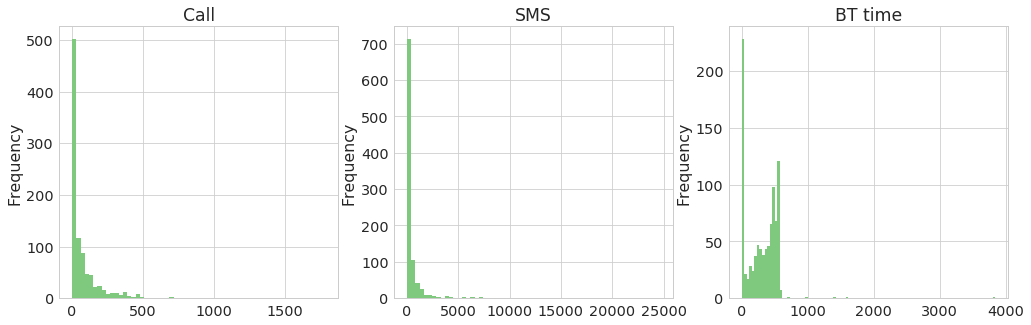

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
dfc.call_count.plot.hist(60, ax=ax1)
dfc.sms_count.plot.hist(60, ax=ax2)
dfc.bt_timespan.dt.days.plot.hist(100, ax=ax3)
ax1.set_title("Call")
ax2.set_title("SMS")
ax3.set_title("BT time")

In [30]:
dfc.all(axis=1).sum() 

75

In [31]:
dfc.filter(regex='_be$').mean().sort_values()

call_count_be       0.125000
sms_count_be        0.168803
call_timespan_be    0.633547
sms_timespan_be     0.657051
bt_timespan_be      0.767094
dtype: float64

In [32]:
dfc.filter(regex='_be$').all(axis=1).sum() 

75

In [33]:
dfc.filter(regex='_be$').all(axis=1).mean() 

0.08012820512820513

In [34]:
df.to_msgpack('../../allan_data/user_data_properties.msgpack')